

## 2.taco_and_burrito


### ライブラリのインストール

In [1]:
!pip install torch torchvision tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = './drive/My Drive'

### ライブラリのインポート

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from tqdm import tqdm

### データセット読み込み

In [0]:
train_imgs = ImageFolder(path + '/train/',
                                             transform=transforms.Compose([
                                                 transforms.RandomCrop(224),
                                                 transforms.ToTensor()]
                                             ))
test_imgs = ImageFolder(path + '/test/',
                                             transform=transforms.Compose([
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor()]
                                             ))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms, utils
from tqdm import tqdm

### データローダー定義

In [0]:
batch_size = 32
train_loader = DataLoader(train_imgs, 
                                               batch_size=batch_size, 
                                               shuffle=True)
test_loader = DataLoader(test_imgs, 
                                              batch_size=batch_size, 
                                              shuffle=False) #shuffleしない

(-0.5, 1125.5, 1125.5, -0.5)

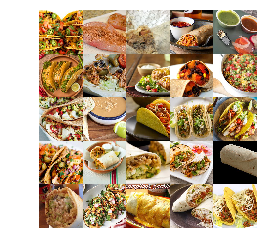

In [8]:
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(train_loader).next()
images, labels = images[:25], labels[:25]
imshow(utils.make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [9]:
train_imgs.classes

['burrito', 'taco']

In [10]:
train_imgs.class_to_idx

{'burrito': 0, 'taco': 1}

### ネットワーク構築

In [11]:
net = models.resnet34(pretrained=True) #事前学習済みモデルをロード

#全てのパラメータを微分対象外に
for p in net.parameters():
    p.requires_grad = False
    
#最後の線形層を付け替える
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 22653093.60it/s]


### 訓練と評価のヘルパー作成

In [0]:
#評価のヘルパー関数
def eval(net, 
               data_loader, 
               device='cpu'):
    net.eval() #DropoutやBatchNorm無効化
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device) #計算を実行するデバイスへ転送
        y = y.to(device)
        with torch.no_grad(): #推論の計算だけなので自動微分に必要な処理off
            _, y_pred = net(x).max(1) #確率が最大のクラスを予測
            ys.append(y)
            ypreds.append(y_pred)
    ys = torch.cat(ys) #ミニバッチごとの予測結果などを一つにまとめる
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys) #予測精度計算
    return acc.item()

In [0]:
#訓練のヘルパー関数
def train(net, 
                train_loader, 
                test_loader, 
                only_fc=True,
                optimizer_cls=optim.Adam, 
                loss_fn=nn.CrossEntropyLoss(), 
                n_iter=10, 
                device='cpu'):
    train_losses = []
    train_acc = []
    val_acc = []
    if only_fc:
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0
        net.train() #訓練モードon
        n = 0
        n_acc = 0
        for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
            x = x.to(device)
            y = y.to(device)
            h = net(x) #順伝播
            loss = loss_fn(h, y) #損失計算
            optimizer.zero_grad() #勾配計算初期化
            loss.backward() #誤差逆伝播
            optimizer.step() #パラメータ更新
            running_loss += loss.item()
            n += len(x)
            _, y_pred = h.max(1) #確率最大クラスを取得
            n_acc += (y == y_pred).float().sum().item()  #精度計算
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n) #訓練データの予測精度
        val_acc.append(eval(net, test_loader, device)) #テストデータの予測精度
        print(f'epoch: {epoch+1}| train_loss: {train_losses[-1]:.5f}|',
                  f'train_acc: {train_acc[-1]:.5f}| val_acc: {val_acc[-1]:.5f}', flush=True)

### 学習実行

In [14]:
net.to('cuda:0') #ネットワークの全パラメータをGPUに転送
train(net, train_loader, test_loader, n_iter=20, device='cuda:0')

100%|██████████| 23/23 [04:43<00:00,  9.75s/it]


epoch: 1| train_loss: 0.68199| train_acc: 0.60815| val_acc: 0.73333


100%|██████████| 23/23 [00:03<00:00,  6.15it/s]


epoch: 2| train_loss: 0.58166| train_acc: 0.73455| val_acc: 0.76667


100%|██████████| 23/23 [00:03<00:00,  6.64it/s]


epoch: 3| train_loss: 0.48251| train_acc: 0.77669| val_acc: 0.83333


100%|██████████| 23/23 [00:03<00:00,  6.78it/s]


epoch: 4| train_loss: 0.42009| train_acc: 0.84551| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.71it/s]


epoch: 5| train_loss: 0.40086| train_acc: 0.83287| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.64it/s]


epoch: 6| train_loss: 0.39028| train_acc: 0.84410| val_acc: 0.80000


100%|██████████| 23/23 [00:03<00:00,  6.65it/s]


epoch: 7| train_loss: 0.38658| train_acc: 0.83287| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.78it/s]


epoch: 8| train_loss: 0.34939| train_acc: 0.87640| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.86it/s]


epoch: 9| train_loss: 0.40694| train_acc: 0.81742| val_acc: 0.86667


100%|██████████| 23/23 [00:03<00:00,  6.63it/s]


epoch: 10| train_loss: 0.38236| train_acc: 0.85253| val_acc: 0.80000


100%|██████████| 23/23 [00:03<00:00,  6.69it/s]


epoch: 11| train_loss: 0.31453| train_acc: 0.88343| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.91it/s]


epoch: 12| train_loss: 0.33224| train_acc: 0.86096| val_acc: 0.80000


100%|██████████| 23/23 [00:03<00:00,  6.80it/s]


epoch: 13| train_loss: 0.33296| train_acc: 0.87360| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.77it/s]


epoch: 14| train_loss: 0.30643| train_acc: 0.88624| val_acc: 0.83333


100%|██████████| 23/23 [00:03<00:00,  6.95it/s]


epoch: 15| train_loss: 0.29818| train_acc: 0.88343| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.81it/s]


epoch: 16| train_loss: 0.32551| train_acc: 0.86657| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.90it/s]


epoch: 17| train_loss: 0.32241| train_acc: 0.87640| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.77it/s]


epoch: 18| train_loss: 0.31411| train_acc: 0.87640| val_acc: 0.81667


100%|██████████| 23/23 [00:03<00:00,  6.72it/s]


epoch: 19| train_loss: 0.31700| train_acc: 0.85393| val_acc: 0.80000


100%|██████████| 23/23 [00:03<00:00,  6.73it/s]


epoch: 20| train_loss: 0.29286| train_acc: 0.88202| val_acc: 0.81667
